In [49]:
import numpy as np
import matplotlib.pyplot as plt

gamma = 0.5

def log_sum_exp(x_k):
    return np.log(np.sum(np.exp(x_k/gamma)))

def W(x,y,v_pair_in):

    w = np.zeros(len(x))
    
    for i in range(len(v_pair_in)):
            t = log_sum_exp(np.array([x[i], x[i+1]]))
            t2 = log_sum_exp(np.array([-x[i],-x[i+1]]))
            t3 = log_sum_exp(np.array([y[i], y[i+1]]))
            t4 = log_sum_exp(np.array([-y[i], -y[i+1]]))
            w[i] = t + t2 + t3 + t4
        
    return gamma*(np.sum(w))

def grad_W(x,y,v_pair_in):
    
    flattened_v_pair = v_pair_in.flatten()
    unique, counts = np.unique(flattened_v_pair, return_counts=True)
    grad_x = np.zeros(len(x))
    grad_y = np.zeros(len(y))
    
    grad_x[0] = ( np.exp(x[0]/gamma)/(np.exp(x[0]/gamma) + np.exp(x[0+1]/gamma)) ) - (np.exp(-x[0]/gamma)/(np.exp(-x[0]/gamma) + np.exp(-x[0+1]/gamma)))
    
    grad_x[1] = ( np.exp(x[1]/gamma)/(np.exp(x[1]/gamma) + np.exp(x[1+1]/gamma)) ) - (np.exp(-x[1]/gamma)/(np.exp(-x[1]/gamma) + np.exp(-x[1+1]/gamma))) + ( np.exp(x[1]/gamma)/(np.exp(x[1]/gamma) + np.exp(x[1-1]/gamma)) ) - (np.exp(-x[1]/gamma)/(np.exp(-x[1]/gamma) + np.exp(-x[1-1]/gamma)))
    
    grad_x[2] = ( np.exp(x[2]/gamma)/(np.exp(x[2]/gamma) + np.exp(x[2-1]/gamma)) ) - (np.exp(-x[2]/gamma)/(np.exp(-x[2]/gamma) + np.exp(-x[2-1]/gamma)))
    
#    for i in unique:
#        if counts[i] == 1 and i == 0:
#            grad_x[i] = np.exp(x[i])/(np.exp(x[i]) + np.exp(x[i+1])) - np.exp(-x[i])/(np.exp(-x[i]) + np.exp(-x[i+1]))
#        elif counts[i] == 1 and i == 2:
#            grad_x[i] = np.exp(x[i])/(np.exp(x[i]) + np.exp(x[i-1])) - np.exp(-x[i])/(np.exp(-x[i]) + np.exp(-x[i-1]))
#        else:
#            mult = [1, -1]
#            for j in range(counts[i]):
#                grad_x[i] = grad_x[i] + np.exp(x[i])/(np.exp(x[i])+np.exp(x[i-1*(mult[j])])) - np.exp(-x[i])/(np.exp(-x[i]) + np.exp(-x[i-1*mult[j]]))
               
  # for i in unique:
  #     if counts[i] == 1 and i == 0:
  #         grad_y[i] = np.exp(y[i]/gamma)/(np.exp(y[i]/gamma) + np.exp(y[i+1]/gamma)) - np.exp(-y[i]/gamma)/(np.exp(-y[i]/gamma) + np.exp(-y[i+1]/gamma))
  #     elif counts[i] == 1 and i == 2:
  #         grad_y[i] = np.exp(y[i]/gamma)/(np.exp(y[i]/gamma) + np.exp(y[i-1]/gamma)) - np.exp(-y[i]/gamma)/(np.exp(-y[i]/gamma) + np.exp(-y[i-1]/gamma))
  #     else:
  #         mult = [1, -1]
  #         for j in range(counts[i]):
  #             grad_y[i] = grad_y[i] + np.exp(y[i]/gamma)/(np.exp(y[i]/gamma)+np.exp(y[i-1*(mult[j])]/gamma)) - np.exp(-y[i]/gamma)/(np.exp(-y[i]/gamma) + np.exp(-y[i-1*mult[j]]/gamma))
                
    grad_y[0] = ( np.exp(y[0]/gamma)/(np.exp(y[0]/gamma) + np.exp(y[0+1]/gamma)) ) - (np.exp(-y[0]/gamma)/(np.exp(-y[0]/gamma) + np.exp(-y[0+1]/gamma)))
    
    grad_y[1] = ( np.exp(y[1]/gamma)/(np.exp(y[1]/gamma) + np.exp(y[1+1]/gamma)) ) - (np.exp(-y[1]/gamma)/(np.exp(-y[1]/gamma) + np.exp(-y[1+1]/gamma))) + ( np.exp(y[1]/gamma)/(np.exp(y[1]/gamma) + np.exp(y[1-1]/gamma)) ) - (np.exp(-y[1]/gamma)/(np.exp(-y[1]/gamma) + np.exp(-y[1-1]/gamma)))
    
    grad_y[2] = ( np.exp(y[2]/gamma)/(np.exp(y[2]/gamma) + np.exp(y[2-1]/gamma)) ) - (np.exp(-y[2]/gamma)/(np.exp(-y[2]/gamma) + np.exp(-y[2-1]/gamma)))
                
    grad_w = np.vstack((grad_x, grad_y))            
    return grad_w, grad_x, grad_y
            

def a(wv,wb):
    return 4/((wv + 2*wb)*(wv + 4*wb))
def b(wv,wb):
    return 2/(wb*(wv+4*wb))

def P(x,wv,wb):
    
    if not np.isscalar(x):
        raise ValueError("Input x (or y) should be a scalar in Px and Py in this iteration of the program.")
        
    if 0 <= x <= (wv / 2 + wb):
        return 1 - a(wv,wb)*(x**2)
    elif (wv / 2 + wb) <= x <= (wv / 2 + 2 * wb):
        return b(wv,wb)*(x - wv/2 - 2*wb)^2
    elif x >= (wv/2+2*wb):
        return 0
    
def D(x,y,a):
    wb = 2
    hb = 2
    t_den = 0.6
    d = np.zeros(len(x))
    for i in range(len(x)):
        d[i] = P(x[i],v_width[i],wb)*P(y[i],v_height[i],hb)
    cv = a / d
    return np.sum(cv*d - t_den*wb*hb)

def sum_bin(x,y,a):
    
    lambda_ = 1
    bin_ = np.zeros(num_bins)
    for i in range(num_bins):
        bin_[i] = D(x,y,a)
        
    return lambda_*np.sum(bin_)
    
        

3.1661831392405704
-5.602153372323315
h: 1.000e+00, 	 err0: 1.106e+00, 	 err1: 8.344e-01
h: 5.000e-01, 	 err0: 3.761e-01, 	 err1: 2.405e-01
h: 2.500e-01, 	 err0: 1.313e-01, 	 err1: 6.354e-02
h: 1.250e-01, 	 err0: 5.013e-02, 	 err1: 1.623e-02
h: 6.250e-02, 	 err0: 2.104e-02, 	 err1: 4.095e-03
h: 3.125e-02, 	 err0: 9.502e-03, 	 err1: 1.028e-03
h: 1.562e-02, 	 err0: 4.494e-03, 	 err1: 2.575e-04
h: 7.812e-03, 	 err0: 2.183e-03, 	 err1: 6.444e-05
h: 3.906e-03, 	 err0: 1.075e-03, 	 err1: 1.612e-05
h: 1.953e-03, 	 err0: 5.336e-04, 	 err1: 4.030e-06
h: 9.766e-04, 	 err0: 2.658e-04, 	 err1: 1.008e-06
h: 4.883e-04, 	 err0: 1.327e-04, 	 err1: 2.519e-07
h: 2.441e-04, 	 err0: 6.627e-05, 	 err1: 6.298e-08
h: 1.221e-04, 	 err0: 3.312e-05, 	 err1: 1.575e-08
h: 6.104e-05, 	 err0: 1.655e-05, 	 err1: 3.936e-09
h: 3.052e-05, 	 err0: 8.276e-06, 	 err1: 9.841e-10
h: 1.526e-05, 	 err0: 4.138e-06, 	 err1: 2.460e-10
h: 7.629e-06, 	 err0: 2.069e-06, 	 err1: 6.151e-11
h: 3.815e-06, 	 err0: 1.034e-06, 	 err1: 1.5

(array([1.e-19, 1.e-17, 1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05,
        1.e-03, 1.e-01, 1.e+01, 1.e+03]),
 [Text(0, 1e-19, '$\\mathdefault{10^{-19}}$'),
  Text(0, 1e-17, '$\\mathdefault{10^{-17}}$'),
  Text(0, 1e-15, '$\\mathdefault{10^{-15}}$'),
  Text(0, 1e-13, '$\\mathdefault{10^{-13}}$'),
  Text(0, 1e-11, '$\\mathdefault{10^{-11}}$'),
  Text(0, 1e-09, '$\\mathdefault{10^{-9}}$'),
  Text(0, 1e-07, '$\\mathdefault{10^{-7}}$'),
  Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$')])

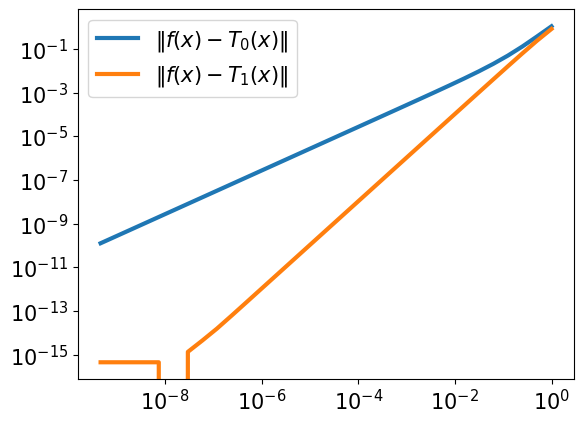

In [50]:
dim = 3
num_edges = 2
num_bins = 1

block_min_width = 0.5
block_max_width = 1

bin_min = 0
bin_max = 2

v_width = np.random.uniform(block_min_width, block_max_width, dim)
v_height = np.random.uniform(block_min_width, block_max_width, dim)

v_area = v_width*v_height

x0 = np.random.uniform(bin_min,bin_max,dim)
y0 = np.random.uniform(bin_min,bin_max,dim)
v_x = np.random.randn(dim)
v_y = np.random.randn(dim)
v_stack = np.vstack((v_x,v_y))

x_len = len(x0)
x = np.concatenate((x0,y0))

#vertex pair indices
v_pair_ind = np.array([[0, 1],[1,2]])


print(W(x0,y0,v_pair_ind))
print(D(x0,y0,v_area))


max_iters = 32
h = np.zeros(max_iters)
err0 = np.zeros(max_iters)
err1 = np.zeros(max_iters)

for i in range(max_iters):
  h[i] = 2**(-i) # halve our stepsize every time

  fv = W(x0 + h[i]*v_x,y0+ h[i]*v_y,v_pair_ind)
  T0 = W(x0,y0,v_pair_ind)
  
  [grad_w, grad_x, grad_y] = grad_W(x0,y0,v_pair_ind)
  
  T1 = T0 + h[i]*np.sum(grad_w* v_stack)

  err0[i] = np.linalg.norm(fv - T0) # this error should be linear
  err1[i] = np.linalg.norm(fv - T1) # this error should be quadratic

  # print('h = ', h, ', err0 = ', err0[i], ', err1 = ', err1[i])

  print('h: %.3e, \t err0: %.3e, \t err1: %.3e' % (h[i], err0[i], err1[i]))
  

plt.loglog(h, err0, linewidth=3)
plt.loglog(h, err1, linewidth=3)
plt.legend([r'$\|f(x) - T_0(x)\|$', r'$\|f(x)-T_1(x)\|$'], fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)